## Implementation and analysis of feature interference of the paper The Elephant in the Room

In [46]:
import sys
import os
import distutils.core
import torch
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

dist = distutils.core.run_setup("../detectron2/setup.py")
sys.path.insert(0, os.path.abspath('../detectron2'))

# import some common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from pycocotools.coco import COCO
import glob
import copy

In [47]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Thu_Jun_11_22:26:48_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.0, V11.0.194
Build cuda_11.0_bu.relgpu_drvr445TC445_37.28540450_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [48]:
setup_logger()

<Logger detectron2 (DEBUG)>

In [49]:
# Load dataset
annotations_path = "../datasets/MSCOCO/annotations/instances_val2017.json"
database_path = "../datasets/MSCOCO/val2017/"
coco_annotation=COCO(annotations_path)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [50]:
print(coco_annotation.info())

description: COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01
None


### Load an image with masks and change inside/outside of bounding boxes

In [51]:
def load_image_with_masks(annotations, img_filename, database_path, instance=-1, outside_distribution='zeros', inside_distribution='original'):
    im = cv2.imread(database_path+img_filename)
    im_id = int(img_filename.split('.')[0])
    annotation_ids = annotations.getAnnIds(imgIds=im_id)
    if instance == -1:
        annotation_id = annotation_ids[random.randint(0, len(annotation_ids)-1)]
    else:
        annotation_id = annotation_ids[instance]
        
    annotation_im  = annotations.loadAnns(annotation_id)[0]
    
    annotation_mask = annotations.annToMask(annotation_im)
    
    # Set everything outside bounding box to certain distribution
    if outside_distribution == 'zeros':
        im_feature_interference = np.zeros(im.shape, dtype=im.dtype)
    elif outside_distribution == 'noise':
        im_feature_interference = np.random.randn(*im.shape).astype(im.dtype)
    elif outside_distribution == 'original':
        im_feature_interference = copy.deepcopy(im)
        
    
    # Now change everything inside the bounding box and apply mask
    if inside_distribution == 'zeros':
        im_feature_interference[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])] = 0
    elif inside_distribution == 'original':
        im_feature_interference[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])] = im[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])]
    elif inside_distribution == 'random':
        im_feature_interference[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])] = np.random.randn(*im.shape).astype(im.dtype)[int(annotation_im['bbox'][1]):int(annotation_im['bbox'][1]+annotation_im['bbox'][3]),
                        int(annotation_im['bbox'][0]):int(annotation_im['bbox'][0]+annotation_im['bbox'][2])]
    
    im_feature_interference[annotation_mask != 0] = im[annotation_mask != 0]
    
    return im, im_feature_interference

im_filename = random.choice(os.listdir(database_path))
im_filename = '000000020247.jpg'

im_orig, im_outside_zeros = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'zeros', 'original')
_, im_all_zeros = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'zeros', 'zeros')
_, im_outside_zeros_inside_noise = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'noise', 'zeros')

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(25, 20)

ax[0].imshow(im_orig)
ax[0].axis('off')
ax[1].imshow(im_outside_zeros)
ax[1].axis('off')
ax[2].imshow(im_all_zeros)
ax[2].axis('off')
ax[3].imshow(im_outside_zeros_inside_noise)
ax[3].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Load model predictor and predict

In [ ]:
cfg = get_cfg()
model = 'mask_rcnn'
if model == 'mask_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
elif model == 'fast_rcnn':
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE='cpu'
predictor = DefaultPredictor(cfg)

[03/25 13:54:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [ ]:
def predict(predictor, img):
    outputs = predictor(img)
    output_predictions = outputs["instances"].pred_classes

    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    output_image= out.get_image()
    return output_image, output_predictions

The Mask-RCNN classifier does not know whether a bear is a dog or a bear with certainty. We can notice that changing features inside the region-of-interest change the prediction, from not knowing whether is a dog or a bear, to just a bear. By contrast, when adding random noise to the outside of the bounding box and discarding all the pixels inside of it the only prediction is a dog.

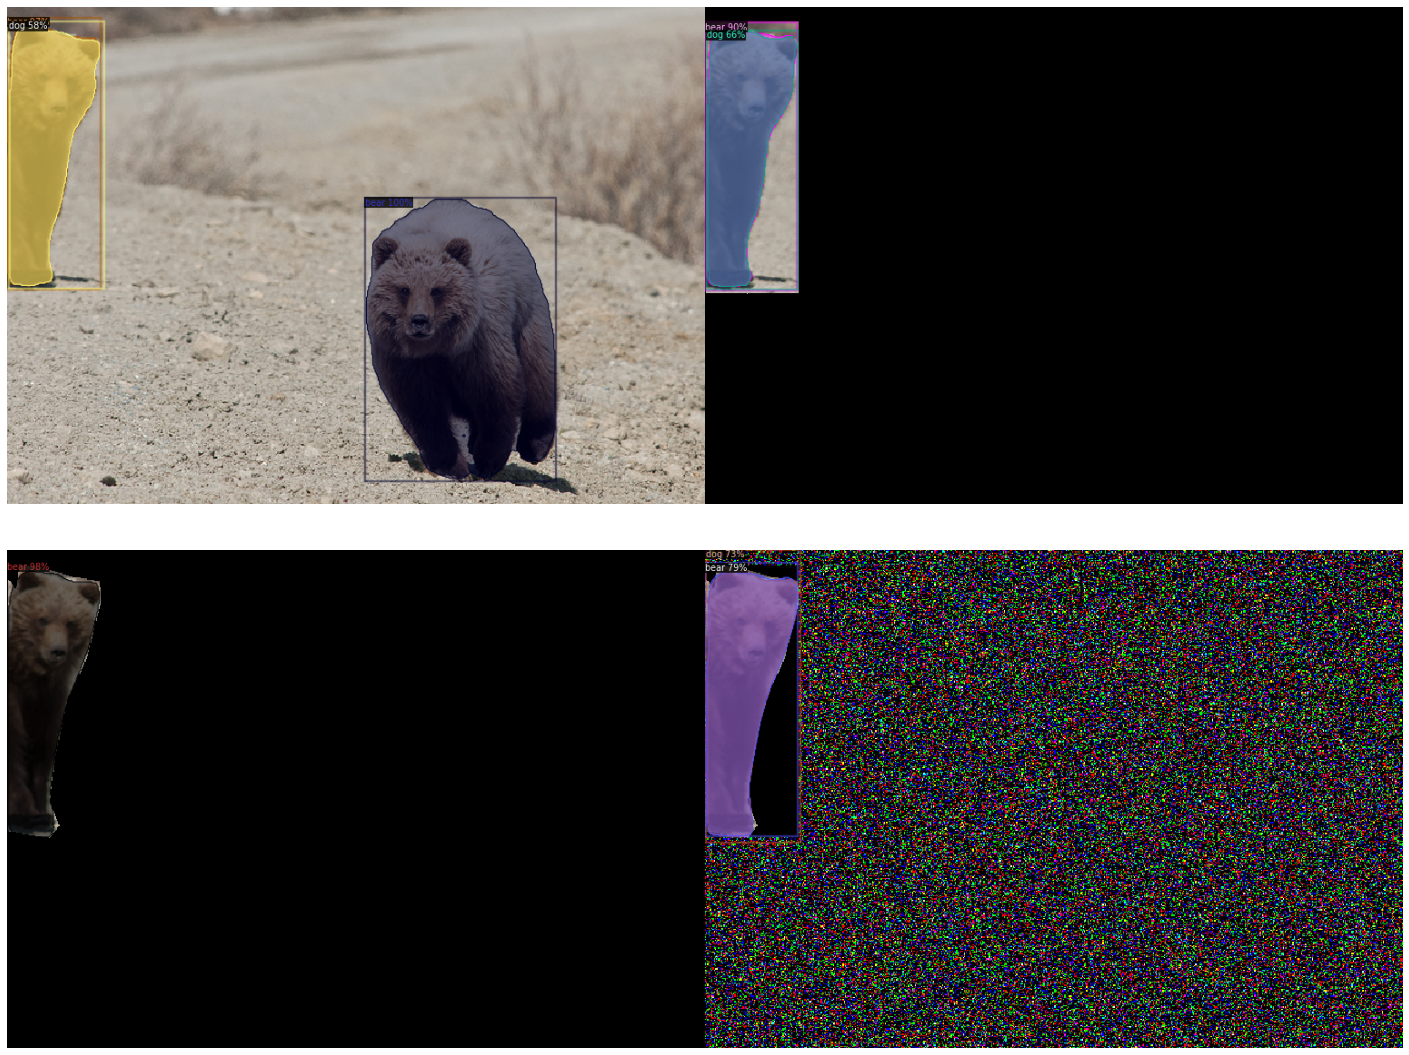

In [ ]:
im_predicted_orig, predictions_orig = predict(predictor, im_orig)
im_predicted_outside_zeros, predictions_outside_zeros = predict(predictor, im_outside_zeros)
im_predicted_all_zeros, predictions_all_zeros = predict(predictor, im_all_zeros)
im_predicted_outside_zeros_inside_noise, predictions_outside_zeros_inside_noise = predict(predictor, im_outside_zeros_inside_noise)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(25, 20)

ax[0,0].imshow(im_predicted_orig)
ax[0,0].axis('off')
ax[0,1].imshow(im_predicted_outside_zeros)
ax[0,1].axis('off')
ax[1,0].imshow(im_predicted_all_zeros)
ax[1,0].axis('off')
ax[1,1].imshow(im_predicted_outside_zeros_inside_noise)
ax[1,1].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Lets try another image

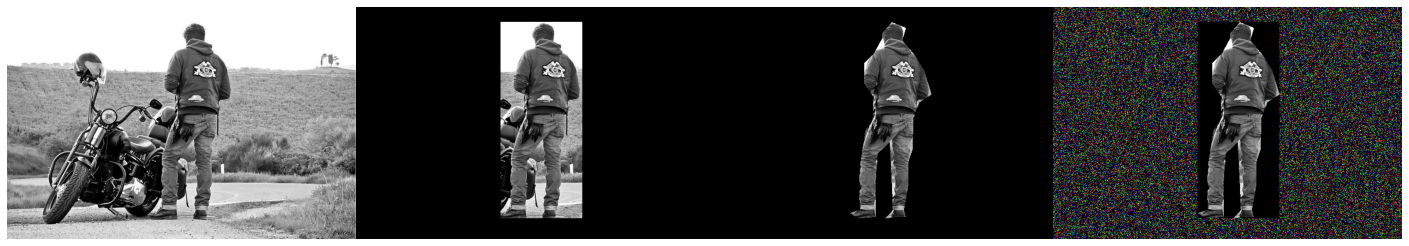

In [ ]:
# im_filename = random.choice(os.listdir(database_path))
im_filename = '000000020247.jpg'

im_orig, im_outside_zeros = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'zeros', 'original')
_, im_all_zeros = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'zeros', 'zeros')
_, im_outside_zeros_inside_noise = load_image_with_masks(coco_annotation, im_filename, database_path, 1, 'noise', 'zeros')

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(25, 20)

ax[0].imshow(im_orig)
ax[0].axis('off')
ax[1].imshow(im_outside_zeros)
ax[1].axis('off')
ax[2].imshow(im_all_zeros)
ax[2].axis('off')
ax[3].imshow(im_outside_zeros_inside_noise)
ax[3].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

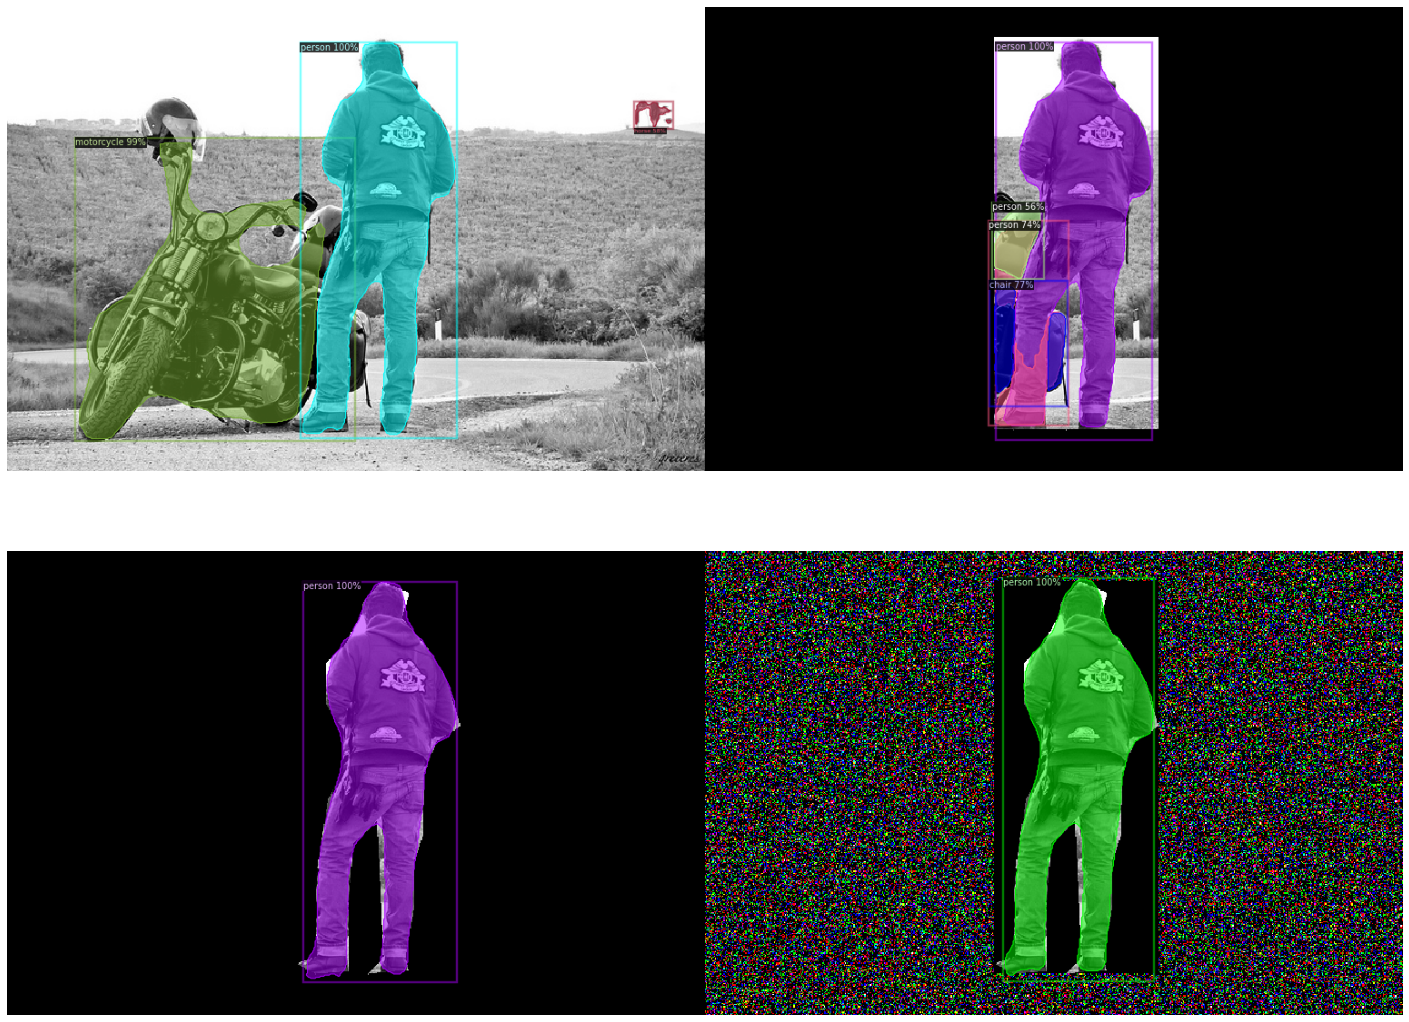

In [ ]:
im_predicted_orig, predictions_orig = predict(predictor, im_orig)
im_predicted_outside_zeros, predictions_outside_zeros = predict(predictor, im_outside_zeros)
im_predicted_all_zeros, predictions_all_zeros = predict(predictor, im_all_zeros)
im_predicted_outside_zeros_inside_noise, predictions_outside_zeros_inside_noise = predict(predictor, im_outside_zeros_inside_noise)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(25, 20)

ax[0,0].imshow(im_predicted_orig)
ax[0,0].axis('off')
ax[0,1].imshow(im_predicted_outside_zeros)
ax[0,1].axis('off')
ax[1,0].imshow(im_predicted_all_zeros)
ax[1,0].axis('off')
ax[1,1].imshow(im_predicted_outside_zeros_inside_noise)
ax[1,1].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Some images used on the paper

In [ ]:
# 000000125211.jpg
# 000000115885.jpg
# 000000125850.jpg
# 000000154947.jpg
# 000000326082.jpg
# 000000119233.jpg
# 000000180383.jpg
# 000000371529.jpg
# 000000519611.jpg